In [1]:
# %matplotlib inline

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle

In [2]:
from tqdm import tqdm

In [3]:
pkl_filename = "pre_processing/times_scaler.pkl"
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

In [4]:
times_scaler

MinMaxScaler(feature_range=(-1, 1))

In [5]:
times = np.load("training_data/times.npy")

In [6]:
times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]

In [7]:
times

array([-499.50442803, -499.00442803, -498.50442803, ...,   48.49557197,
         48.99557197,   49.49557197])

In [8]:
times_scaled

array([-1.        , -0.99817851, -0.99635701, ...,  0.99635701,
        0.99817851,  1.        ])

In [9]:
times.shape

(1099,)

In [10]:
times_scaled.shape

(1099,)

In [11]:
amps = np.load("training_data/amplitude.npy")
amp_processing_params = np.load("pre_processing/amp_preprocessing_params.npz")

# amps = np.load("training_data/phase.npy")
# amp_processing_params = np.load("pre_processing/phase_preprocessing_params.npz")

In [12]:
amps.shape

(500, 1099)

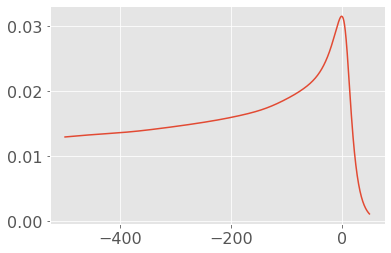

In [13]:
plt.figure()
plt.plot(times, amps[0])

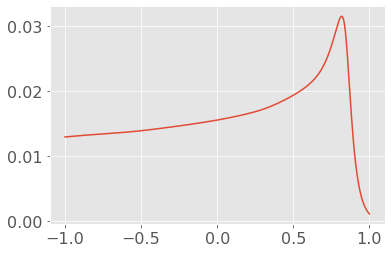

In [14]:
plt.figure()
plt.plot(times_scaled, amps[0])

In [15]:
list(amp_processing_params)

['mean', 'max']

In [16]:
amp_processing_params['mean']

array([[0.01255005, 0.01255297, 0.01255593, ..., 0.00125779, 0.00120668,
        0.00115758]])

In [17]:
amp_processing_params['mean'].shape

(1, 1099)

In [18]:
amp_processing_params['max']

array(0.00714663)

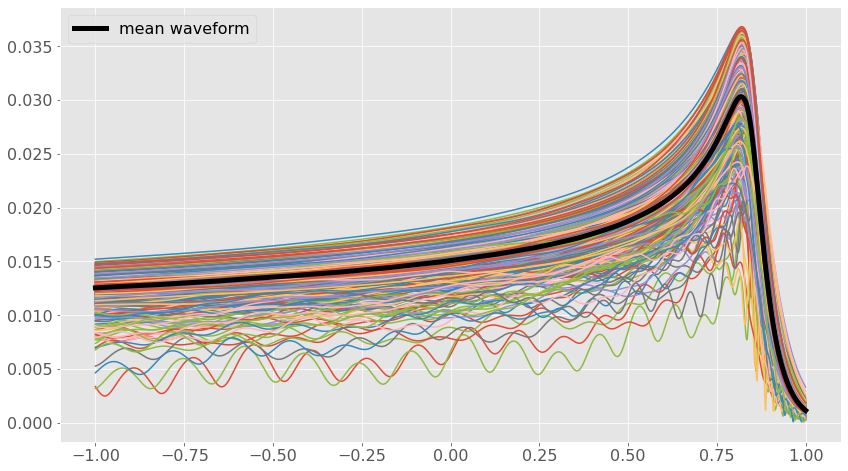

In [19]:
plt.figure(figsize=(14, 8))
for y in amps:
    plt.plot(times_scaled, y)
    
plt.plot(times_scaled, amp_processing_params['mean'][0], label='mean waveform', lw=5, c='k')
plt.legend()

In [20]:
import compute_preprocessing

In [21]:
amps_scaled = compute_preprocessing.apply_pre_process_forward(amps, amp_processing_params['mean'], amp_processing_params['max'])

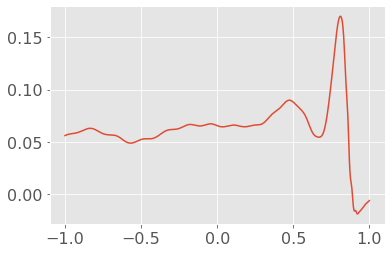

In [22]:
plt.figure()
plt.plot(times_scaled, amps_scaled[0])

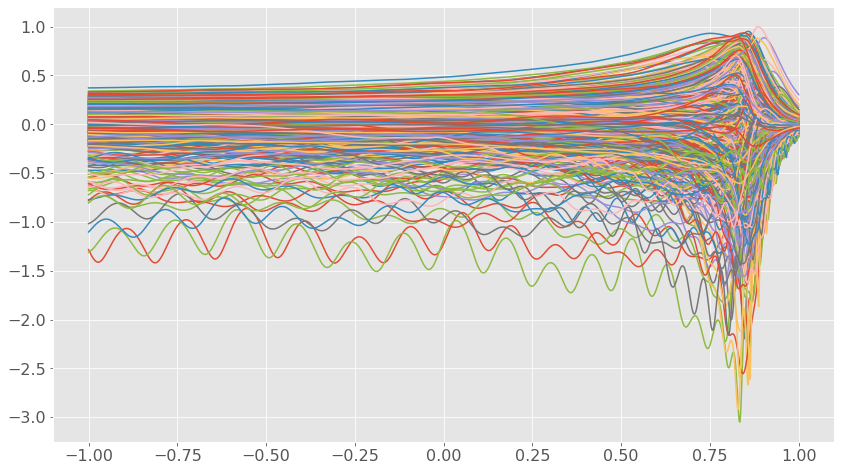

In [23]:
plt.figure(figsize=(14, 8))
for y in amps_scaled:
    plt.plot(times_scaled, y)
#     plt.plot(times, y)
# plt.xlim(-100, 100)

In [24]:
amps_scaled_reverse = compute_preprocessing.apply_pre_process_reverse(amps_scaled, amp_processing_params['mean'], amp_processing_params['max'])

In [25]:
np.testing.assert_array_almost_equal(amps, amps_scaled_reverse)

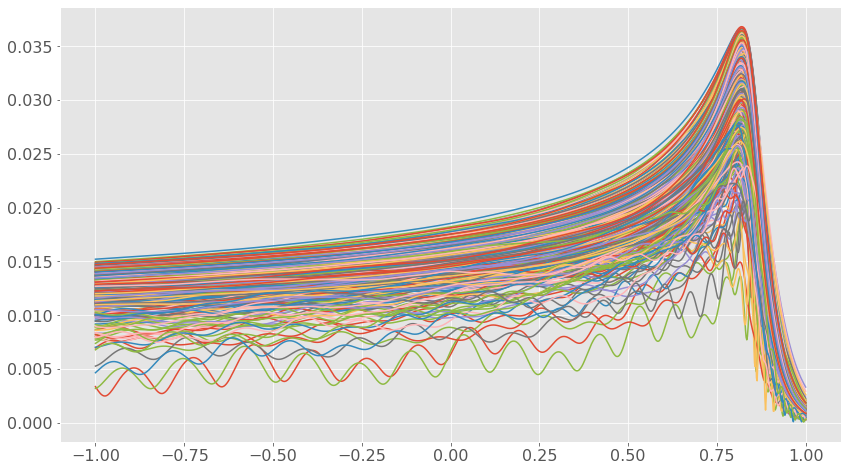

In [26]:
plt.figure(figsize=(14, 8))
for y in amps_scaled_reverse:
    plt.plot(times_scaled, y)

# setting up the domain

In [73]:
coords = np.load("training_data/coords.npy")

In [74]:
times.shape

(1099,)

In [75]:
coords.shape

(3, 500)

In [76]:
amps.shape

(500, 1099)

In [77]:
np.outer(coords, times).shape

(1500, 1099)

In [78]:
(times[:, np.newaxis]*coords[0]).shape

(1099, 500)

In [79]:
1099 * 3

3297

In [80]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [81]:
X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

In [82]:
y = amps.ravel()
print(y.shape)

# X = []


# # for b,c,d in coords.T:

# bb = coords[0]
# cc = coords[1]
# dd = coords[2]

# for b,c,d in zip(bb,cc,dd):
#     for a in times_scaled:
# #         print(a,b,c,d)
#         X.append([a,b,c,d])
# X = np.asarray(X)

(549500,)


In [83]:
# coords[0]

In [84]:
# coords[1]

In [85]:
# coords[2]*180/np.pi

In [86]:
X.shape

(549500, 4)

In [87]:
X[2]

array([-0.99635701,  2.03547937,  0.2632761 ,  1.29650135])

In [88]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], y)

In [89]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,2], y)

In [90]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,3], y)

In [91]:
plt.figure()
plt.scatter(X[:,0], y, s=1)

# load model

In [92]:
import tensorflow as tf

In [93]:
import pugna.layers
import pugna.activations

In [94]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [95]:
# model = tf.keras.models.load_model("fit/model.h5",
#                                    custom_objects={'Mscale': pugna.layers.Mscale,
#                                                   'Activation':tf.keras.layers.Activation,
#                                                   'name':pugna.activations.s2relu})
# model = tf.keras.models.load_model("TEST_amplitude_fit/model.h5",
#                                    custom_objects={'Mscale': pugna.layers.Mscale,
#                                                   'Activation':tf.keras.layers.Activation,
#                                                   'name':pugna.activations.s2relu})
# model = tf.keras.models.load_model("fit/model.h5")
# model = tf.keras.models.load_model("amplitude_fit/model.h5")
# model = tf.keras.models.load_model("TEST_amplitude_fit/model.h5")
# model = tf.keras.models.load_model("phase_fit/model.h5")

model = tf.keras.models.load_model("amplitude_fit_resnet/model.h5")

In [96]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128)          0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [98]:
# model.layers[2].activation

In [99]:
# model.layers[3].activation.activation.activation

In [100]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output
    

In [101]:
coords.shape

(3, 500)

In [102]:
coords[1];

In [103]:
%%time
errors = []

for index in tqdm(range(coords.shape[1])):

    output = compute_model_input(times_scaled, *coords[:,index])
    output.shape
    yhat = model.predict(output).T

    yhat = compute_preprocessing.apply_pre_process_reverse(yhat, amp_processing_params['mean'], amp_processing_params['max'])
    errors.append(100*(yhat[0]-amps[index])/amps[index])
#     errors.append((yhat[0]-amps[index]))
errors = np.array(errors)

100%|██████████| 500/500 [02:40<00:00,  3.11it/s]

CPU times: user 3min 6s, sys: 9.77 s, total: 3min 16s
Wall time: 2min 40s


In [111]:
max_errors = np.max(np.abs(errors), axis=1)

In [112]:
max_errors.shape

(500,)

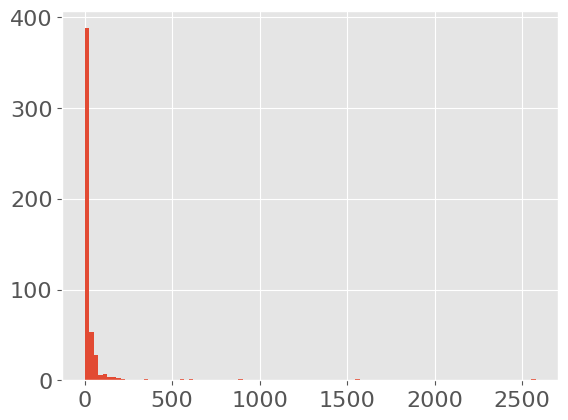

In [113]:
plt.figure()
plt.hist(max_errors, bins=100);
plt.show()
plt.close()

In [114]:
# mask = max_errors > 0.2
mask = max_errors > 10

In [115]:
max_errors.shape

(500,)

In [116]:
max_error_indices = np.array([np.where(max_errors == m_e)[0][0] for m_e in max_errors[mask]])

In [117]:
max_error_indices

array([  7,  10,  14,  15,  18,  20,  21,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  33,  34,  36,  38,  39,  40,  42,  43,  44,  47,
        49,  53,  54,  55,  56,  57,  58,  60,  62,  63,  65,  68,  69,
        70,  71,  72,  74,  76,  78,  79,  80,  81,  85,  87,  88,  89,
        90,  91,  92,  96,  98, 101, 103, 104, 106, 109, 110, 111, 112,
       114, 115, 117, 118, 119, 123, 124, 125, 126, 127, 129, 130, 131,
       134, 135, 136, 137, 138, 139, 140, 141, 143, 145, 146, 148, 149,
       151, 155, 156, 157, 158, 159, 161, 162, 163, 167, 168, 169, 171,
       173, 175, 176, 177, 178, 181, 183, 184, 185, 186, 187, 188, 189,
       190, 192, 194, 195, 198, 199, 203, 204, 206, 207, 208, 209, 211,
       212, 213, 214, 215, 217, 218, 219, 221, 222, 224, 225, 226, 229,
       230, 232, 233, 234, 239, 242, 243, 246, 247, 248, 249, 250, 254,
       258, 259, 260, 263, 267, 268, 269, 271, 272, 273, 275, 276, 279,
       280, 281, 282, 283, 284, 285, 286, 290, 291, 292, 293, 29

In [118]:
max_error_indices.shape

(319,)

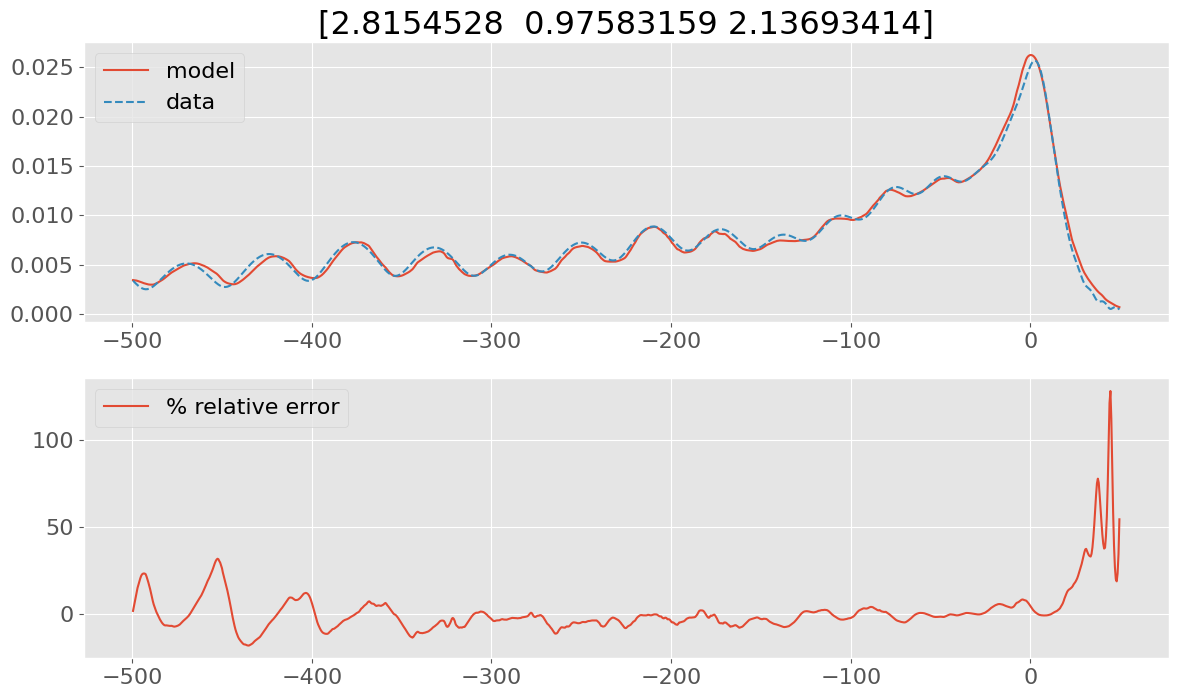

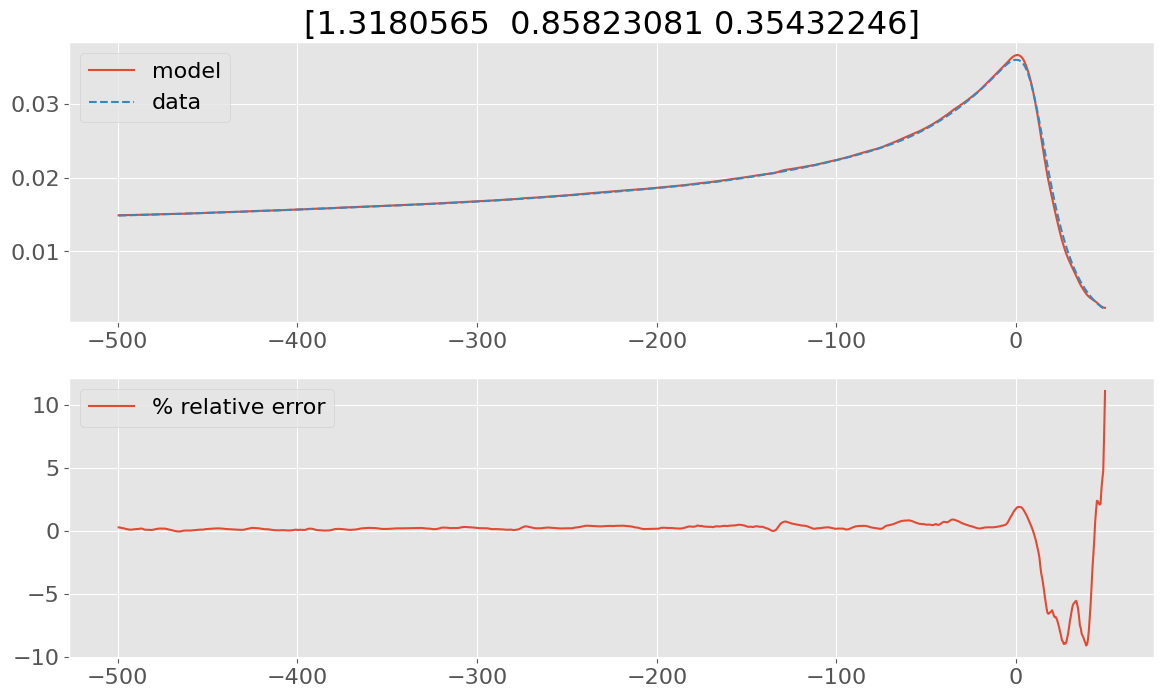

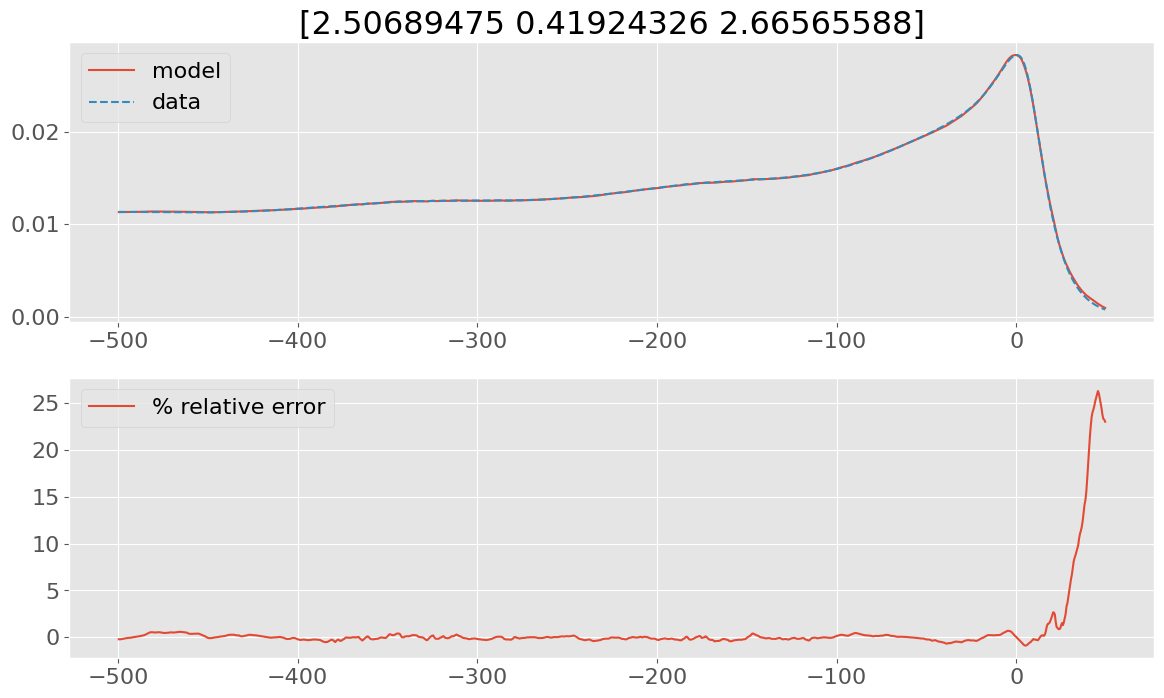

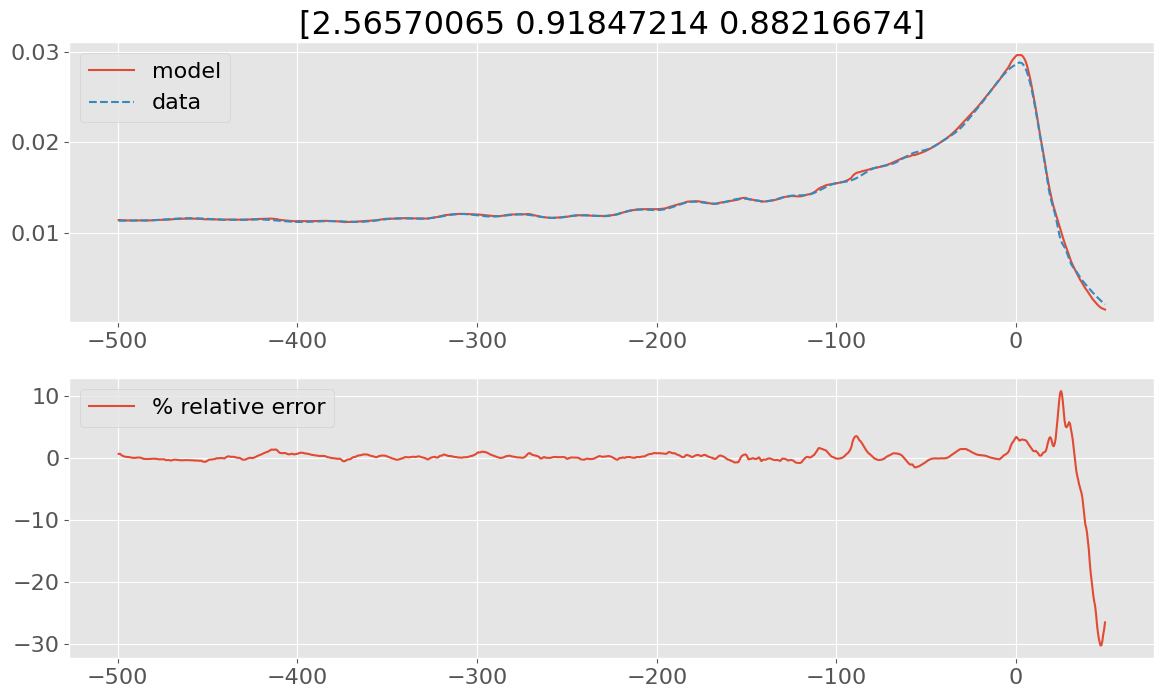

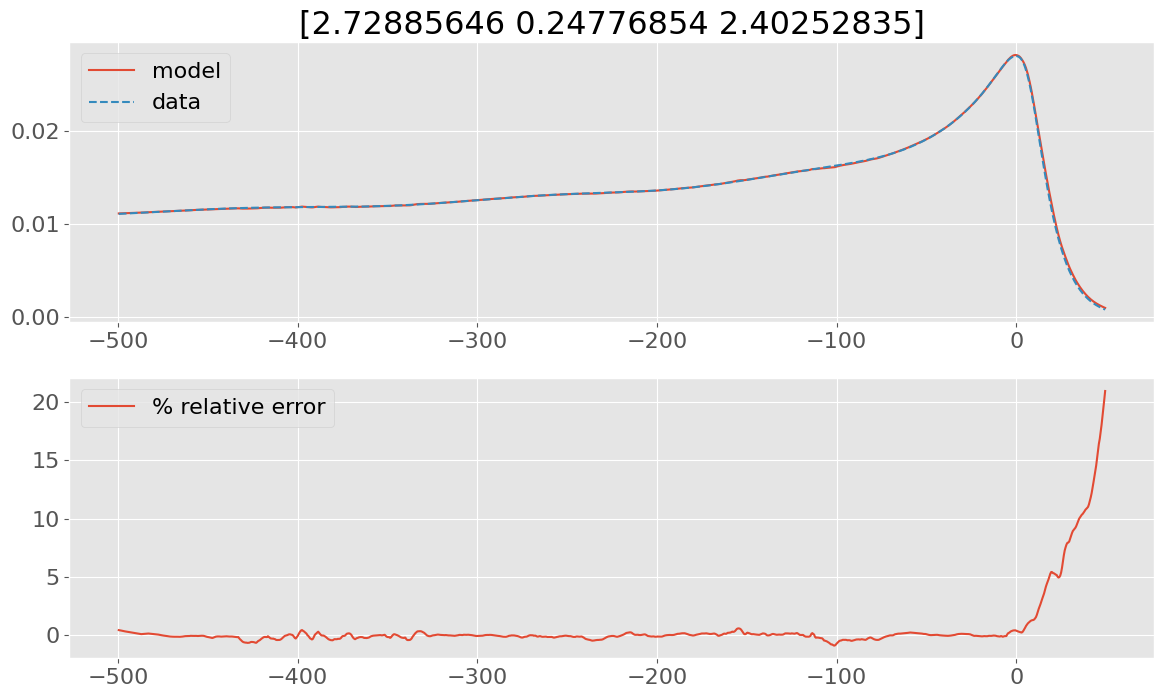

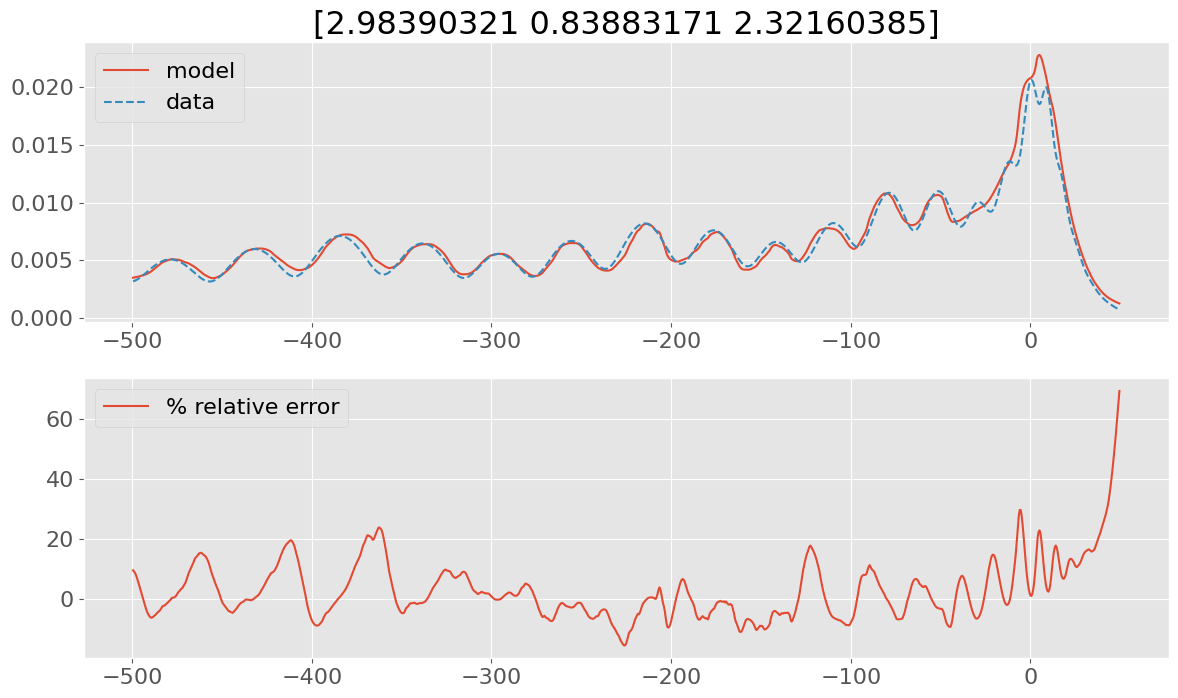

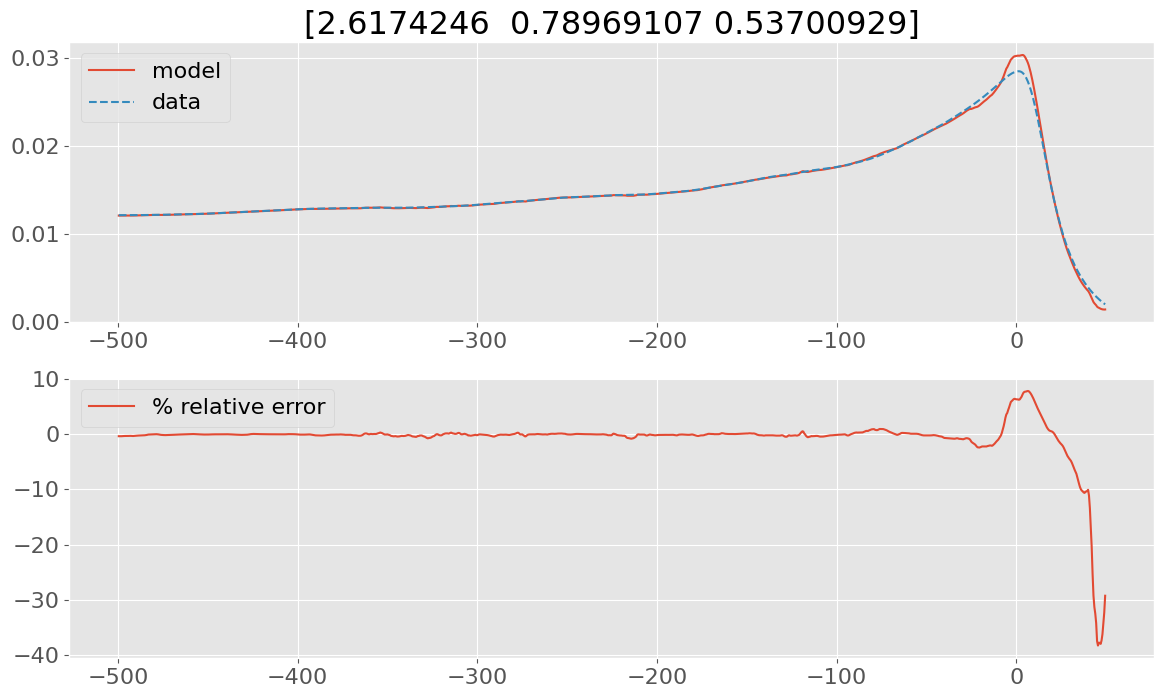

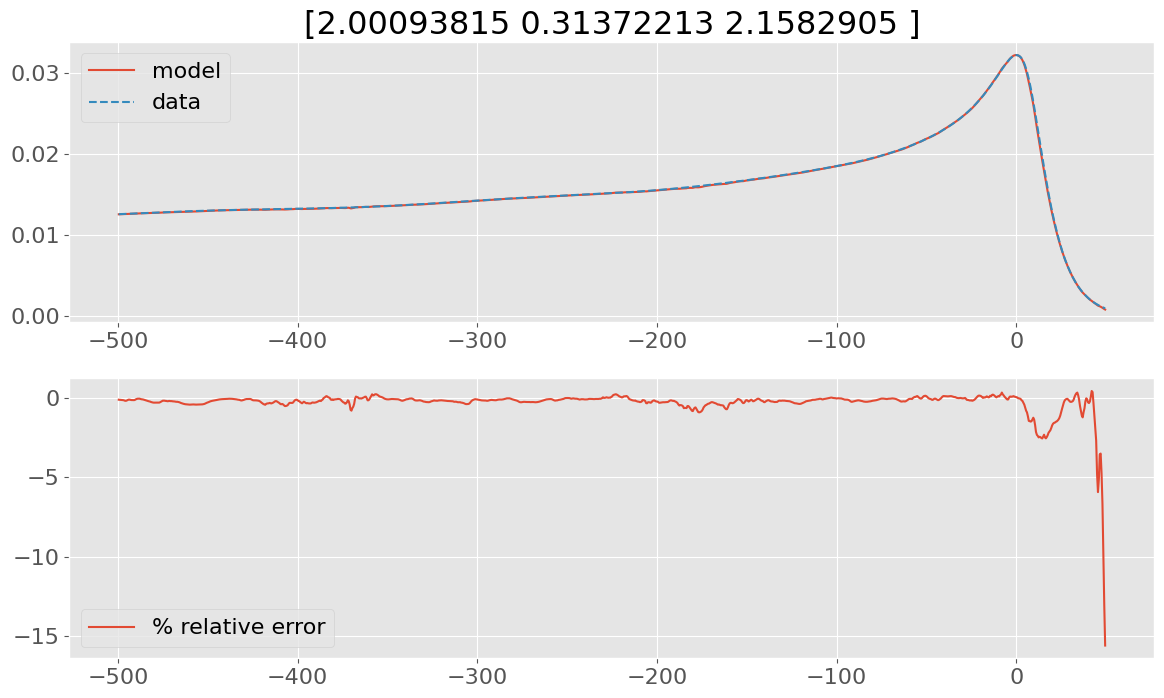

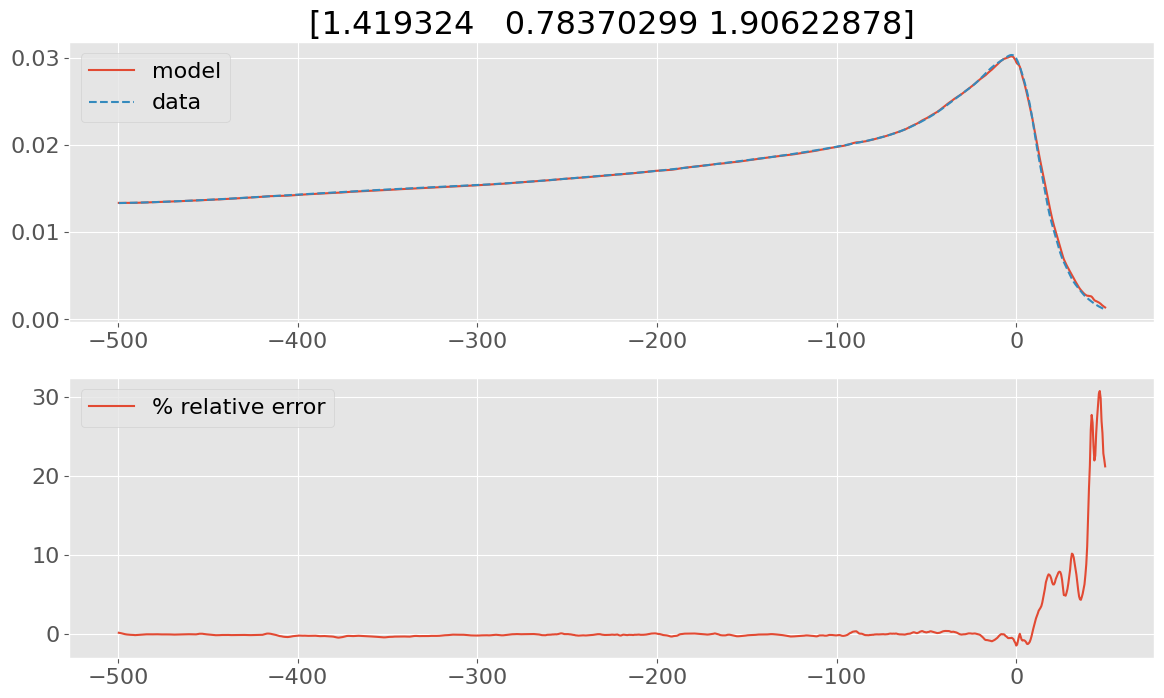

In [119]:
# index = -4

# for index in range(coords.shape[1]):
# for index in range(10):
# for index in range(10, 30):
# for index in range(450, 460):
# for index in max_error_indices:
for index in max_error_indices[:20]:

    output = compute_model_input(times_scaled, *coords[:,index])
    output.shape
    yhat = model.predict(output).T
    # yhat = model.predict(X)
    # yhat = model.predict(X[int(1099*1):int(1099*2)])
    yhat.shape
    yhat = compute_preprocessing.apply_pre_process_reverse(yhat, amp_processing_params['mean'], amp_processing_params['max'])
    yhat.shape
    plt.figure(figsize=(14,8))
    plt.subplot(2, 1, 1)
    plt.plot(times, yhat[0], label='model')
    plt.plot(times, amps[index], label='data', ls='--')
#     plt.plot(times, amps_scaled[index], ls='--')
    plt.title(f"{coords[:,index]}")
#     plt.xlim(-100, 50)
#     plt.ylim(-80, -40)
    plt.legend()

    plt.subplot(2, 1, 2)
#     plt.plot(times, yhat[0]-amps[index])
    plt.plot(times, 100*(yhat[0]-amps[index])/amps[index], label='% relative error')
#     plt.plot(times, (yhat[0]-amps[index]), label='error')
#     plt.plot(times, yhat[0]-amps_scaled[index], label='error')
    # plt.title(f"{coords[:,index]}")
    plt.legend()
    
    plt.show()
    plt.close()

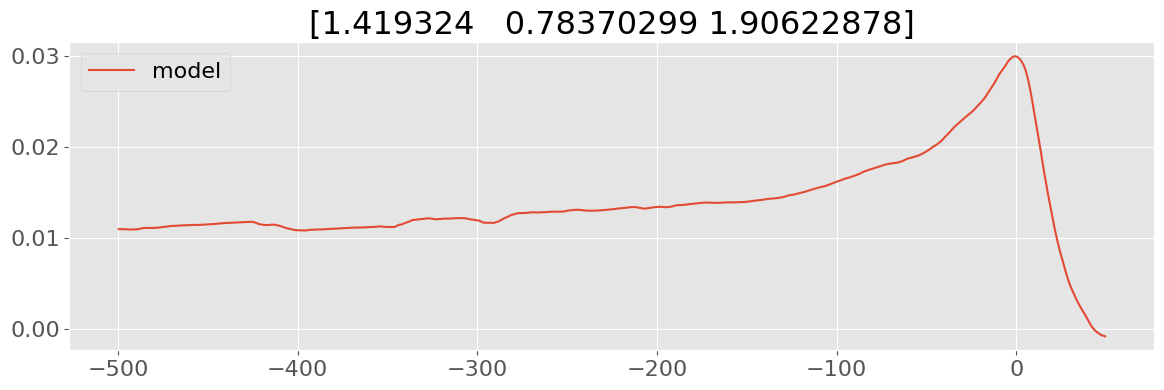

In [123]:
output = compute_model_input(times_scaled, *[2, 0.81, 2.9])
output.shape
yhat = model.predict(output).T
# yhat = model.predict(X)
# yhat = model.predict(X[int(1099*1):int(1099*2)])
yhat.shape
yhat = compute_preprocessing.apply_pre_process_reverse(yhat, amp_processing_params['mean'], amp_processing_params['max'])
yhat.shape
plt.figure(figsize=(14,4))
plt.plot(times, yhat[0], label='model')
plt.title(f"{coords[:,index]}")
# plt.xlim(-100, 50)
plt.legend()
plt.show()
plt.close()


In [124]:
yhat.shape

(1, 1099)

In [125]:
times.shape

(1099,)

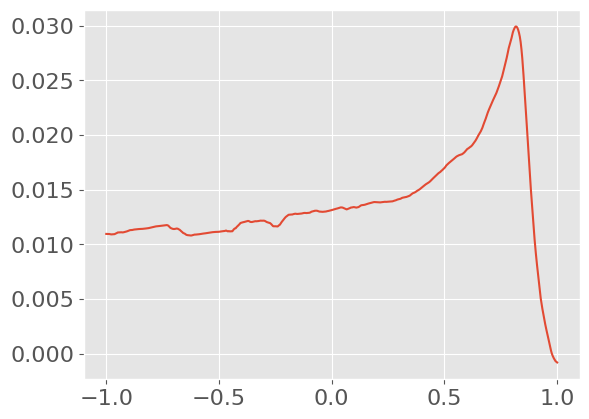

In [128]:
plt.figure()
plt.plot(times_scaled, yhat[0])
plt.show()
plt.close()